In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np
import os

print("Librerías importadas exitosamente.")

Librerías importadas exitosamente.


In [7]:
try:
    df_transacciones = pd.read_excel('dataset_ventas.xlsx')
    print(f"Archivo Excel cargado, {len(df_transacciones)} transacciones encontradas.")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'dataset_ventas.xlsx'.")
    print("Asegúrate de que esté en la misma carpeta que este notebook.")
except Exception as e:
    print(f"Error al leer el Excel: {e}")

# 2. Convertir la columna de fecha a formato datetime
# (Usa el nombre de tu columna, en la imagen es 'InvoiceDate')
df_transacciones['InvoiceDate'] = pd.to_datetime(df_transacciones['InvoiceDate'])

# 3. Calcular el total de cada transacción
# (Usa los nombres de tus columnas, en la imagen son 'Quantity' y 'Price')
df_transacciones['TotalVenta'] = df_transacciones['Quantity'] * df_transacciones['Price']

# 4. (MAGIA) Agrupar todo por día (Resample)
# 'D' significa 'Diario'. Suma todas las 'TotalVenta' de cada día.
df_ventas = df_transacciones.set_index('InvoiceDate')['TotalVenta'].resample('D').sum().fillna(0)

# 5. Convertir a un DataFrame con el nombre de columna correcto
df_ventas = df_ventas.to_frame(name='total_ventas')

print("\nDatos procesados y agregados por día:")
df_ventas.tail()

Archivo Excel cargado, 525461 transacciones encontradas.

Datos procesados y agregados por día:


,total_ventas
InvoiceDate,
2010-12-05,31383.95
2010-12-06,53860.18
2010-12-07,45059.05
2010-12-08,44189.84
2010-12-09,52532.13


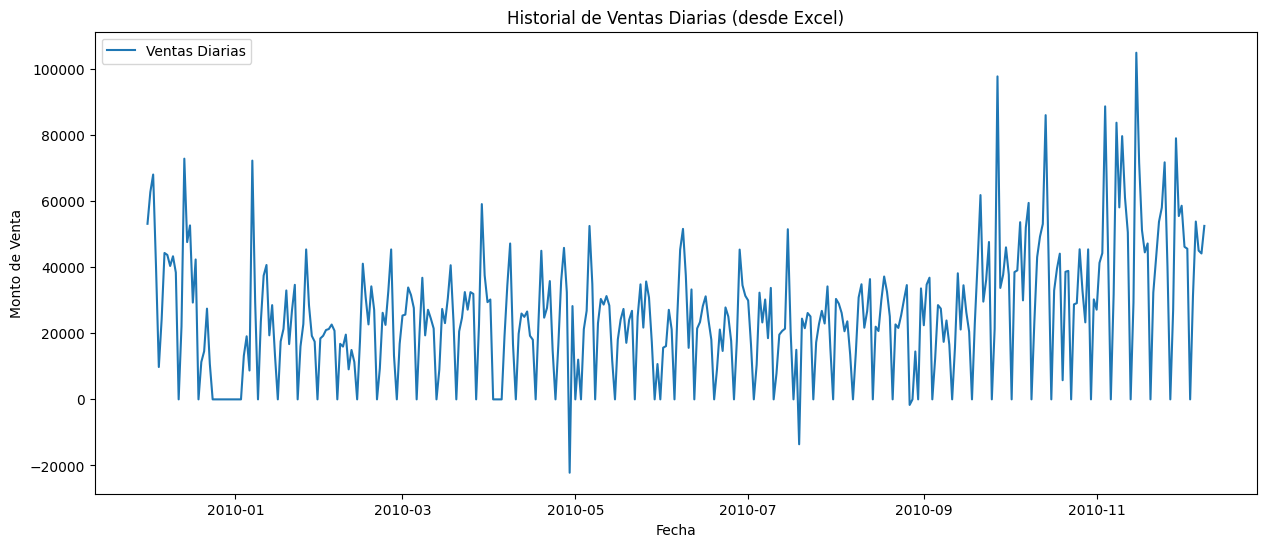

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(df_ventas['total_ventas'], label='Ventas Diarias')
plt.title('Historial de Ventas Diarias (desde Excel)')
plt.xlabel('Fecha')
plt.ylabel('Monto de Venta')
plt.legend()
plt.show()

In [9]:
def crear_features(df):
    """Crea características de series de tiempo a partir de un índice de fecha."""
    df_copy = df.copy()
    df_copy['dia_del_mes'] = df_copy.index.day
    df_copy['dia_de_la_semana'] = df_copy.index.dayofweek  # Lunes=0, Domingo=6
    df_copy['mes'] = df_copy.index.month
    df_copy['anio'] = df_copy.index.year
    df_copy['trimestre'] = df_copy.index.quarter
    
    # Característica "Lag" (Ventas del día anterior)
    df_copy['ventas_dia_anterior'] = df_copy['total_ventas'].shift(1)
    
    # Característica "Rolling" (Promedio de la última semana)
    df_copy['media_ventas_7_dias'] = df_copy['total_ventas'].shift(1).rolling(window=7).mean()
    
    # Llenamos los valores 'NaN' (primeros 7 días) con 0
    df_copy = df_copy.fillna(0)
    
    return df_copy

df_features = crear_features(df_ventas)

print("Datos con nuevas características (features):")
df_features.tail()

Datos con nuevas características (features):


,total_ventas,dia_del_mes,dia_de_la_semana,mes,anio,trimestre,ventas_dia_anterior,media_ventas_7_dias
InvoiceDate,,,,,,,,
2010-12-05,31383.95,5,6,12,2010,4,0.00,44592.421429
2010-12-06,53860.18,6,0,12,2010,4,31383.95,45206.042857
2010-12-07,45059.05,7,1,12,2010,4,53860.18,41604.672857
2010-12-08,44189.84,8,2,12,2010,4,45059.05,40109.497143
2010-12-09,52532.13,9,3,12,2010,4,44189.84,38045.822857


In [10]:
TARGET = 'total_ventas'
FEATURES = [col for col in df_features.columns if col != TARGET]

X = df_features[FEATURES]
y = df_features[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

print(f"Total de días: {len(X)}")
print(f"Días para entrenar: {len(X_train)}")
print(f"Días para probar: {len(X_test)}")

modelo = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("\nEntrenando el modelo...")
modelo.fit(X_train, y_train)
print("¡Modelo entrenado!")

score = modelo.score(X_test, y_test)
print(f"\nPuntuación del modelo (R-squared): {score:.2f}")

Total de días: 374
Días para entrenar: 299
Días para probar: 75

Entrenando el modelo...
¡Modelo entrenado!

Puntuación del modelo (R-squared): 0.36


In [11]:
# Guardamos el modelo en la carpeta 'modelo/'
# (Recuerda que estamos en 'notebooks/', así que usamos '../modelo/')
ruta_guardado = '../modelo/modelo_random_forest.pkl'

# Asegurarse de que el directorio 'modelo' exista
os.makedirs('../modelo', exist_ok=True)

joblib.dump(modelo, ruta_guardado)

print(f"¡Modelo guardado exitosamente en: {ruta_guardado}")

¡Modelo guardado exitosamente en: ../modelo/modelo_random_forest.pkl
